# Titanic - Exploratory Data Analysis and Machine Learning

Dataset: Titanic - Machine Learning from Disaster (Kaggle)

Goal:
- Explore the data (EDA)
- Understand which factors influenced survival
- Build classification models to predict Survived

In [2]:
# import neccesary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
#load Dataset
titanic_path = "train.csv"
titanic = pd.read_csv(titanic_path)

print("Dataset shape:", titanic.shape)
titanic.head()

Dataset shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
'''
Initial Exploration
Goals
- Inspect data types
- Check missing values
- Look at basic statistics
'''

print("==== Info ===")
titanic.info()

print("\n=== Missing values per column ===")
print(titanic.isna().sum())

print("\n=== Descriptive statistics (numeric) ===")
print(titanic.describe())

==== Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

=== Missing values per column ===
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin

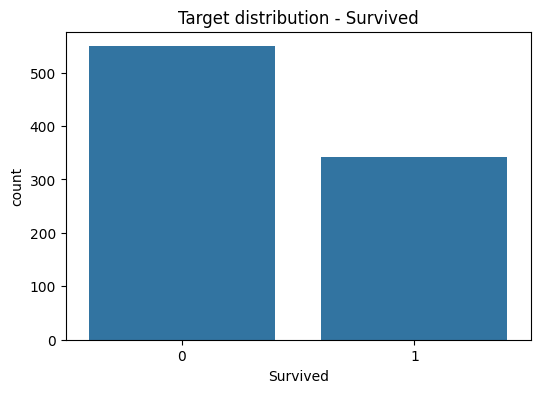

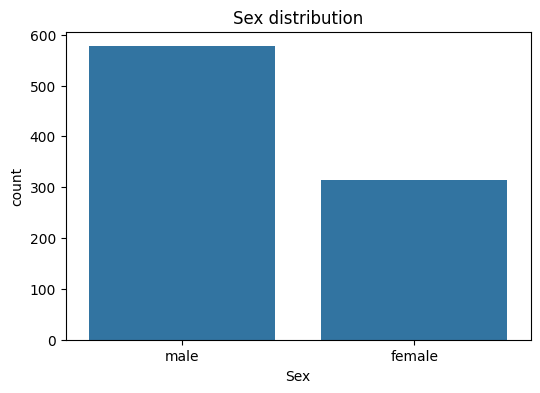

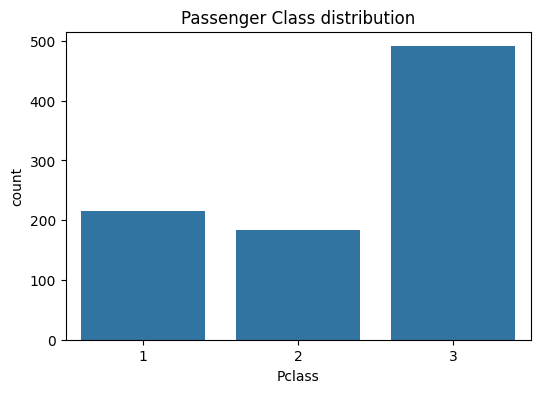

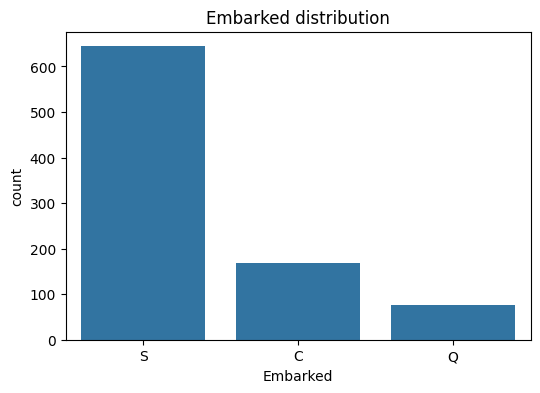

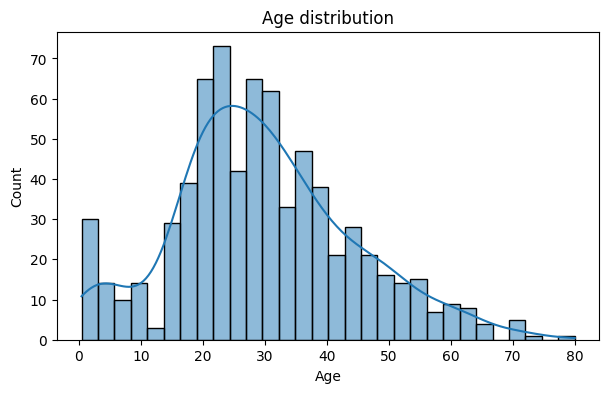

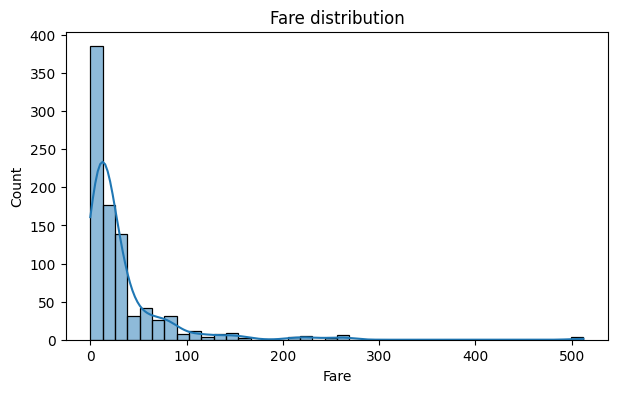

In [6]:
"""
Exploratory Data Analysis (EDA)

- Target distribution (`Survived`)
- Categorical variables (`Sex`, `Pclass`, `Embarked`)
- Numerical variables (`Age`, `Fare`)

"""

# Target: Survived
plt.figure(figsize=(6, 4))
sns.countplot(data=titanic, x="Survived")
plt.title("Target distribution - Survived")
plt.show()

# Sex
plt.figure(figsize=(6, 4))
sns.countplot(data=titanic, x="Sex")
plt.title("Sex distribution")
plt.show()

# Pclass
plt.figure(figsize=(6, 4))
sns.countplot(data=titanic, x="Pclass")
plt.title("Passenger Class distribution")
plt.show()

# Embarked
plt.figure(figsize=(6, 4))
sns.countplot(data=titanic, x="Embarked")
plt.title("Embarked distribution")
plt.show()

# Age distribution
plt.figure(figsize=(7, 4))
sns.histplot(titanic["Age"], bins=30, kde=True)
plt.title("Age distribution")
plt.xlabel("Age")
plt.show()

# Fare distribution
plt.figure(figsize=(7, 4))
sns.histplot(titanic["Fare"], bins=40, kde=True)
plt.title("Fare distribution")
plt.xlabel("Fare")
plt.show()


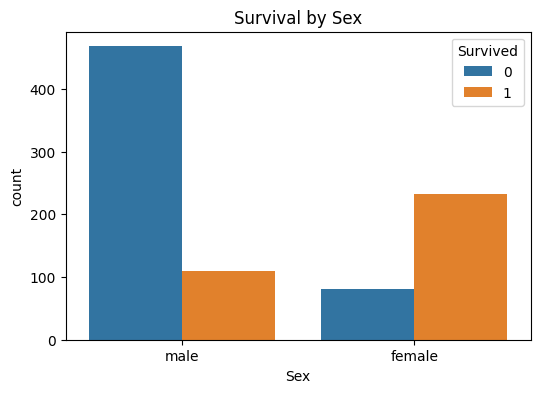

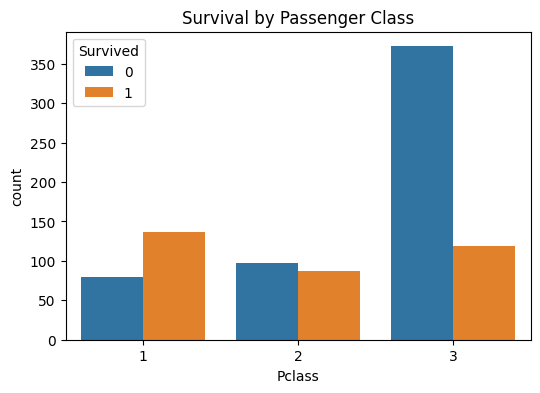

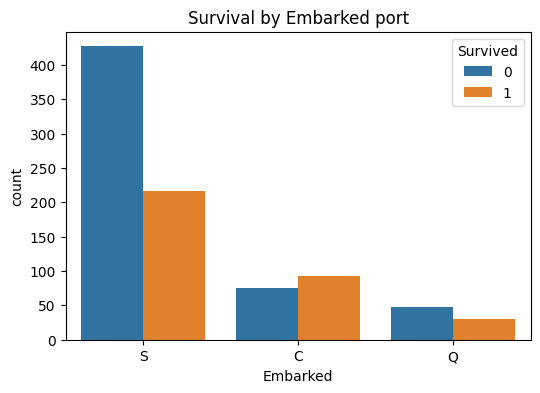

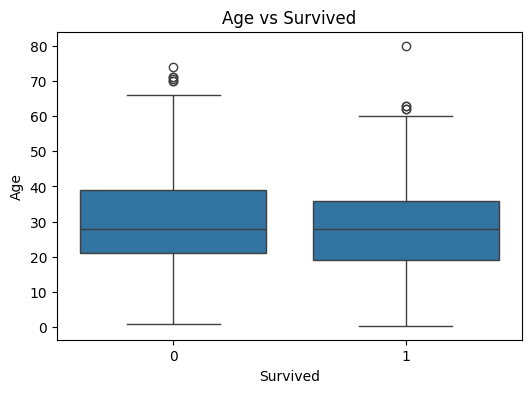

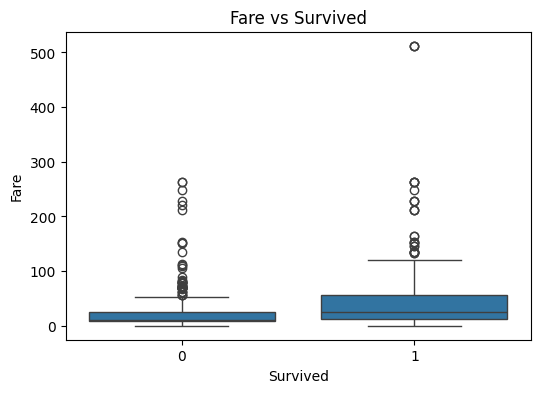

In [7]:
"""
Bivariate EDA

We now explore how `Survived` relates to other variables:
- `Sex`
- `Pclass`
- `Embarked`
- `Age`, `Fare`
"""

# Survival by Sex
plt.figure(figsize=(6, 4))
sns.countplot(data=titanic, x="Sex", hue="Survived")
plt.title("Survival by Sex")
plt.show()

# Survival by Pclass
plt.figure(figsize=(6, 4))
sns.countplot(data=titanic, x="Pclass", hue="Survived")
plt.title("Survival by Passenger Class")
plt.show()

# Survival by Embarked
plt.figure(figsize=(6, 4))
sns.countplot(data=titanic, x="Embarked", hue="Survived")
plt.title("Survival by Embarked port")
plt.show()

# Age vs Survived (boxplot)
plt.figure(figsize=(6, 4))
sns.boxplot(data=titanic, x="Survived", y="Age")
plt.title("Age vs Survived")
plt.xlabel("Survived")
plt.ylabel("Age")
plt.show()

# Fare vs Survived (boxplot)
plt.figure(figsize=(6, 4))
sns.boxplot(data=titanic, x="Survived", y="Fare")
plt.title("Fare vs Survived")
plt.xlabel("Survived")
plt.ylabel("Fare")
plt.show()

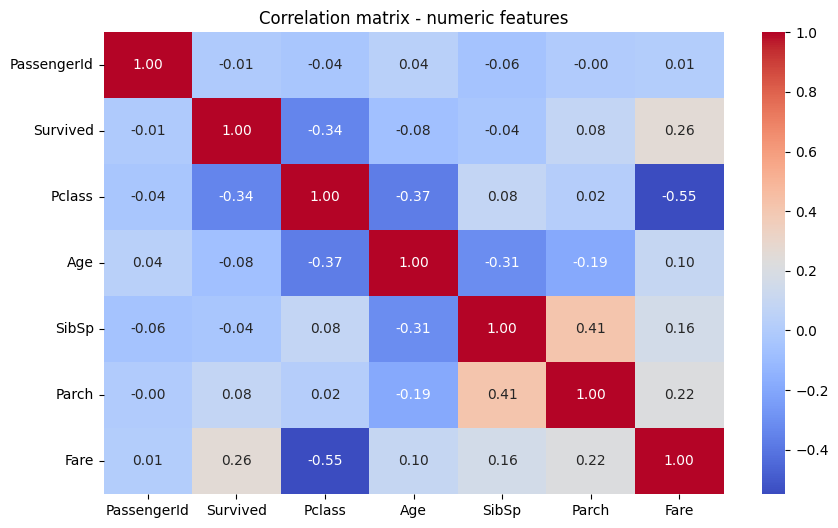

In [9]:
"""
Correlation Matrix (numeric features only)
"""

numeric_cols = titanic.select_dtypes(include=["int64", "float64"]).columns
corr = titanic[numeric_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix - numeric features")
plt.show()

In [11]:
'''
Data Preprocessing

Goals include:
- Select a subset of useful features
- Handle missing values
- Split dataset into train and test
- Build a preprocessing pipeline:
  - Standardize numeric features
  - One-hot encode categorical features

'''

# Selected features and target
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
target = "Survived"

data_model = titanic[features + [target]].copy()

# Handle missing values:
# - Age: fill with median
# - Fare: fill with median
# - Embarked: fill with mode
data_model["Age"] = data_model["Age"].fillna(data_model["Age"].median())
data_model["Fare"] = data_model["Fare"].fillna(data_model["Fare"].median())
data_model["Embarked"] = data_model["Embarked"].fillna(data_model["Embarked"].mode()[0])

# Separate X and y
X = data_model[features]
y = data_model[target]

# Column types
categorical_features = ["Sex", "Embarked"]
numeric_features = [col for col in features if col not in categorical_features]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Preprocessor:
# - StandardScaler for numeric
# - OneHotEncoder for categorical
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


Numeric features: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical features: ['Sex', 'Embarked']


In [12]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (712, 7)
Test shape: (179, 7)



#Modeling

###Models for this study case:
- Logistic Regression
- Random Forest

###We will evaluate:
- Accuracy
- Classification report
- Confusion matrix
- ROC-AUC



=== Logistic Regression ===
Accuracy: 0.8044692737430168
ROC-AUC: 0.844532279314888

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       110
           1       0.79      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



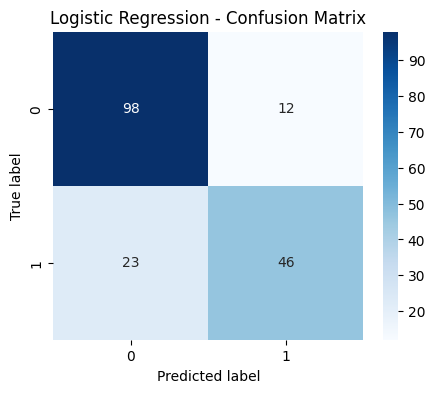

<Figure size 600x400 with 0 Axes>

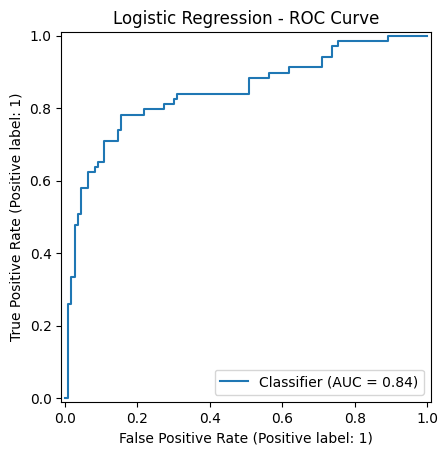

In [15]:
# Logistic Regression


log_reg = LogisticRegression(max_iter=1000)

log_reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", log_reg)
])

# Train
log_reg_pipeline.fit(X_train, y_train)

# Predict
y_pred_log = log_reg_pipeline.predict(X_test)
y_proba_log = log_reg_pipeline.predict_proba(X_test)[:, 1]

# Metrics
print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_log))
print("\nClassification report:")
print(classification_report(y_test, y_pred_log))

# Confusion matrix
cm_log = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# ROC curve
plt.figure(figsize=(6, 4))
RocCurveDisplay.from_predictions(y_test, y_proba_log)
plt.title("Logistic Regression - ROC Curve")
plt.show()

=== Random Forest ===
Accuracy: 0.8212290502793296
ROC-AUC: 0.8299736495388669

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       110
           1       0.81      0.70      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



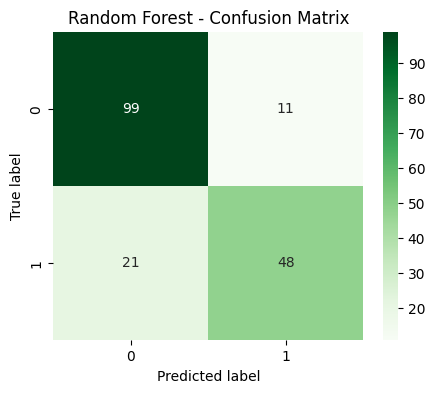

<Figure size 600x400 with 0 Axes>

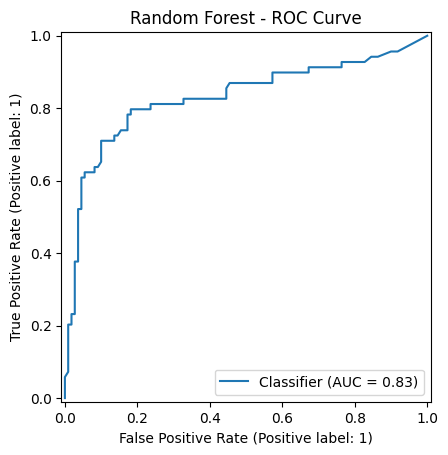

In [16]:
# Random Forest

rf_clf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf_clf)
])

# Train
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# Metrics
print("=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("\nClassification report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# ROC curve
plt.figure(figsize=(6, 4))
RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title("Random Forest - ROC Curve")
plt.show()



      feature  importance
4        Fare    0.257261
1         Age    0.242199
6    Sex_male    0.150436
5  Sex_female    0.140790
0      Pclass    0.087280
2       SibSp    0.045844
3       Parch    0.039519
9  Embarked_S    0.016805
7  Embarked_C    0.012009
8  Embarked_Q    0.007856


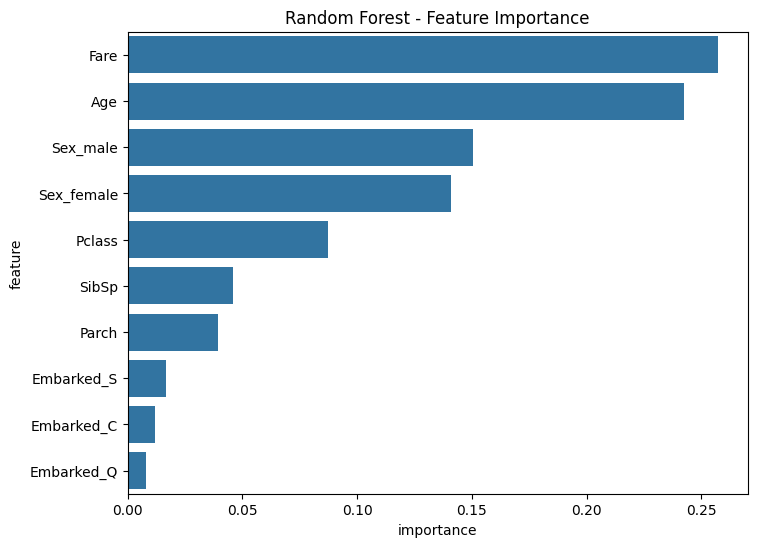

In [17]:

# Feature Importance


# Get trained RandomForest model from pipeline
rf_model = rf_pipeline.named_steps["model"]

# Get feature names from the preprocessor
ohe = rf_pipeline.named_steps["preprocessor"].named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([numeric_features, ohe_feature_names])

feature_importances = rf_model.feature_importances_

importance_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": feature_importances
}).sort_values(by="importance", ascending=False)

print(importance_df)

plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df, x="importance", y="feature")
plt.title("Random Forest - Feature Importance")
plt.show()

# Conclusions

##Generic conclusions
Survival on the Titanic was not random.
It depended heavily on social, demographic, and economic factors:
Women were prioritized during rescue.

Wealthier passengers (1st class) had easier access to lifeboats.
Children had a moderately higher chance of survival.

Ticket fare and port of embarkation provided additional, but smaller, predictive signals.

## Model performance conlusions

The Random Forest model performed better than Logistic Regression,
achieving higher accuracy and ROC-AUC.
Feature importance analysis confirmed that:

- Sex (female)
- Pclass
- Fare
- Age

Were the most influential variables.